# 1-eda-brief.ipynb

Exploratory Data Analysis using conda environment `pycaret3`, accompanying the manuscript:<br>
"Assessment of self-reported executive function in irritable bowel syndrome using a machine learning framework"<br> 
(overleaf: https://www.overleaf.com/project/641372a5904da63d1548c286)

Authors:<br>
Astri J Lundervold, Eline M Hillestad, Julie Billing, Tina E  Johnsen, Gülen A Lied, Elisabeth Steinsvik, Trygve Hausken, Birgitte Berentsen and Arvid Lundervold.

Arvid Lundervold 2023-03-27<br>
Last updatd: 2023-03-29


In [1]:
import os
import sys
import platform
from itertools import repeat
import numpy as np
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import var
from math import sqrt
import statsmodels
from statsmodels.stats.weightstats import ttest_ind  # Welsch t-test
import statsmodels.api as sm
import sklearn
from sklearn.preprocessing import KBinsDiscretizer
import pycaret
from os.path import expanduser
home = expanduser("~")

In [2]:
print('Numpy:', np.__version__)
print('Scipy:', scipy.__version__)
print('Pandas:', pd.__version__)
print('Statsmodels:', statsmodels.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-learn:', sklearn.__version__)
print('Pycaret:', pycaret.__version__)

Numpy: 1.23.5
Scipy: 1.9.3
Pandas: 1.5.3
Statsmodels: 0.13.5
Seaborn: 0.12.2
Scikit-learn: 1.2.2
Pycaret: 3.0.0


In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/Executive_function_in_IBS'
    TREE = '/usr/local/bin/tree -L 1'          # MacOS (brew install tree)
    MacOS = True
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    OVERLEAF_dir = f'/media/arvid/prj2/Dropbox/Apps/Overleaf/Executive_function_in_IBS'
    TREE = '/usr/bin/tree -L 4'
    MacOS = False
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 22.3.0: Mon Jan 30 20:42:11 PST 2023; root:xnu-8792.81.3~2/RELEASE_X86_64)


## Read  .csv file into Pandas dataframe

In [4]:
df = pd.read_csv(f'./data/questionnaire_BRIEF_and_more_66x18.csv')

In [5]:
df.shape

(66, 18)

In [6]:
df.columns

Index(['BG_ID', 'Group', 'Gender', 'Age', 'Inhibition', 'Shifting',
       'Emotional_control', 'Self_monitoring', 'Initiate', 'Working_memory',
       'Planning', 'Task_monitoring', 'Organization', 'HADS_anx', 'HADS_dep',
       'HADS_tot', 'IBS-SSS', 'RBANS'],
      dtype='object')

In [7]:
max_length = max(len(item) for item in list(df.columns))
max_length

17

In [8]:
df1_cols = ['BG_ID', 'Group', 'Gender', 'Age', 'Inhibition', 'Shifting',
       'Emotional_control', 'Self_monitoring', 'Initiate', 'Working_memory',
       'Planning', 'Task_monitoring', 'Organization']

In [9]:
df1a = df.copy()
df1 = df1a[df1_cols]
df1.shape

(66, 13)

In [10]:
df2a = df.dropna()
#col_list = list(df2a)
#col_list[-2], col_list[-1] = col_list[-1], col_list[-2]
#df2b = df2a[col_list]
df2 = df2a
df2.shape

(57, 18)

## EDA

A Gentle Introduction to Effect Size Measures in Python<br>

- https://machinelearningmastery.com/effect-size-measures-in-python
- https://www.analyticsvidhya.com/blog/2022/08/statistical-effect-size-and-python-implementation
- https://stats.stackexchange.com/questions/153450/how-do-i-calculate-the-effect-size-of-an-unequal-sample-size-independent-t-test
- https://grabngoinfo.com/power-analysis-for-sample-size-using-python


### Define some utility functions

In [11]:
def interpret_cohens_d(cohens_d):
    """
    Determines text interpretation of effect size given Cohen's d value

    :param cohens_d: float of Cohen's d value
    :returns: effect_size_interpretation: adjective to describe magnitude of effect size
    """
    if 0<=cohens_d<0.1:
        effect_size_interpretation = "Very Small"
    elif 0.1<=cohens_d<0.35:
        effect_size_interpretation = "Small"
    elif 0.35<=cohens_d<0.65:
        effect_size_interpretation = "Medium"
    elif 0.65<=cohens_d<0.9:
        effect_size_interpretation = "Large"
    elif cohens_d >= 0.9:
        effect_size_interpretation = "Very Large"
    return effect_size_interpretation

In [12]:
def cohen_d(values_1, values_2):
    """
    Function to calculate Cohen's d for independent samples

    :param values_1: array of values in group 1
    :param values_2: array of values in group 2 
    :returns: d:  Cohen's d
    """
    x = values_1
    y = values_2

    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    
    # Calculate Cohen's d
    d = (np.mean(x) - np.mean(y)) / pooled_std
    
    return d

In [13]:
def visualize_variable_dist_IBS_HC(df_adhoc_IBS, df_adhoc_HC, var_name, var_print, cohens_d_function):


   arr_IBS = df_adhoc_IBS[var_name].values
   len_IBS = len(arr_IBS)
   mean_arr_IBS = np.mean(arr_IBS)

   arr_HC = df_adhoc_HC[var_name].values  
   len_HC = len(arr_HC)
   mean_arr_HC = np.mean(arr_HC)

   d = '{:.2f}'.format(np.round(cohens_d_function(arr_IBS, arr_HC), 2))

   grp_IBS = list(repeat('IBS', len_IBS))
   grp_HC = list(repeat('HC', len_HC))

   df_IBS = pd.DataFrame({var_name: arr_IBS, 'Group':  grp_IBS })
   df_HC = pd.DataFrame({var_name: arr_HC, 'Group': grp_HC})

   df_IBS_HC = pd.concat([df_IBS , df_HC ], ignore_index=True, sort=False)


   sns.displot(df_IBS_HC, x=var_name, kind="kde", hue="Group", rug=True, fill=True, aspect=2.0, multiple="layer") # "stack",
   #           height=8, aspect=1.7)
   plt.ylabel("Density")
   plt.xlabel(var_print)
   plt.title(f"Distribution of {var_print} in the IBS (n={len_IBS}) and the HC (n={len_HC}) groups; Cohen's d = {d}", fontsize=16)

   plt.axvline(mean_arr_IBS, color="black", linestyle="dashed")
   #plt.vlines(mean_arr_IBS, 0.0, 0.001, color="blue", linestyle="dashed")
   plt.axvline(mean_arr_HC, color="black", linestyle="dashed")
   #plt.vlines(mean_arr_HC, 0.0, 0.001, color="orange", linestyle="dashed")

   #plt.show()

In [14]:
def add_blanks(s, length):
    """Add blanks to a string to achieve the desired length"""
    if len(s) >= length:
        return s
    else:
        num_blanks = length - len(s)
        return s + ' ' * num_blanks

In [15]:
def transform_underscore(string):
    return string.replace('_', '\_');

In [16]:
def make_latex_table_IBS_HC(OVERLEAF, OVERLEAF_dir, table_tex, clin_scale_list, df_cat_IBS, df_cat_HC, cohend_func, length):


    OVERLEAF = OVERLEAF # True or False

    stdout = sys.stdout

    if OVERLEAF:
        print(f'Writing to {OVERLEAF_dir}/{table_tex} for synching of LaTeX table!')
        # Open the file in write mode
        sys.stdout = open(f'{OVERLEAF_dir}/{table_tex}', 'w')
    else:
        sys.stdout = stdout
        
    print('\\begin{tabular}{l|c|c|c|c|}')
    print(f"Clinical Scale      &    Mean     &     SD     & p-value & Cohen's d \\\\")
    print(f'                    &  IBS / HC   &  IBS / HC  &         &            \\\\')
    print(f'\hline')
    for i, n in enumerate(clin_scale_list):
       m = add_blanks(n, length)
    
       mu_IBS = np.round(df_cat_IBS[n].mean(), 1)
       mu_HC = np.round(df_cat_HC[n].mean(), 1) 
    
       s_IBS = np.round(df_cat_IBS[n].std(), 1)
       s_HC = np.round(df_cat_HC[n].std(), 1) 
    
       arr_IBS = df_cat_IBS[n].values
       arr_HC = df_cat_HC[n].values 
    
       # Perform the t-test using Welch's t-test which assumes unequal variances
       results = ttest_ind(arr_IBS, arr_HC, usevar='unequal')
       p_val = np.round(results[1], 3)
       if results[1] < 0.001:
          p_val_print = '$<$ 0.001'
       else:
          p_val_print = '{:.3f}'.format(p_val)
        
       # The Cohen's d effect size measure is used to determine the standardized difference between the means of two groups
       d = '{:.2f}'.format(np.round(cohen_d(arr_IBS, arr_HC), 2))

       print(f'{transform_underscore(m)}   & {mu_IBS} / {mu_HC} & {s_IBS} / {s_HC}  &  {p_val_print}    &   {d}      \\\\')    

    print('\\end{tabular}')
    print(f'% n_IBS: {len(df_cat_IBS)}, n_HC: {len(df_cat_HC)}')

    sys.stdout = stdout
    if OVERLEAF:
       print('Latex table wiritten to disk')
    OVERLEAF = False

**Check some of the features in the data set**

In [17]:
df[['Group','BG_ID']].groupby('Group').count()

,BG_ID
Group,
HC,22
IBS,44


In [18]:
df[['Gender','BG_ID']].groupby('Gender').count()

,BG_ID
Gender,
F,49
M,17


In [19]:
df[['Group', 'Gender', 'BG_ID']].groupby(['Group', 'Gender']).count()

BG_ID
Group Gender       
HC    F          15
      M           7
IBS   F          34
      M          10

In [20]:
variable_name = 'Age'

In [21]:
# Estimate the Age density using a Gaussian kernel
data = np.asarray(list(df['Age'].values))
kde = gaussian_kde(data)

In [22]:
# Set up the binning for the density estimate
x_min = data.min()
x_max = data.max()
num_bins = 100
x_range = np.linspace(x_min, x_max, num_bins)

In [23]:
# Evaluate the density estimate at each bin
density_estimate = kde.evaluate(x_range)

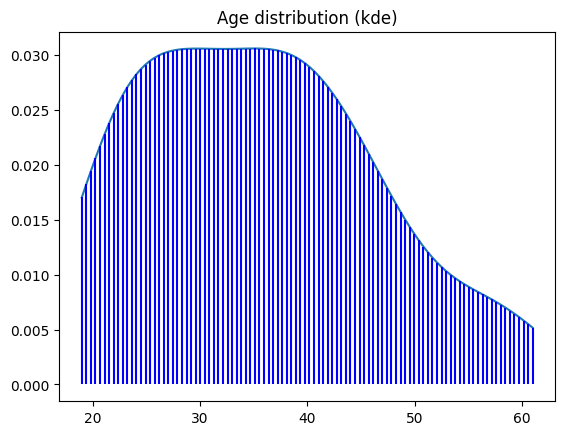

In [24]:
plt.plot(x_range, density_estimate)
# multiple lines with varying ymin and ymax
plt.vlines(x=list(x_range), ymin=0 , ymax=list(density_estimate), colors='blue')
plt.title('Age distribution (kde)')
plt.show()

<Figure size 1000x600 with 0 Axes>

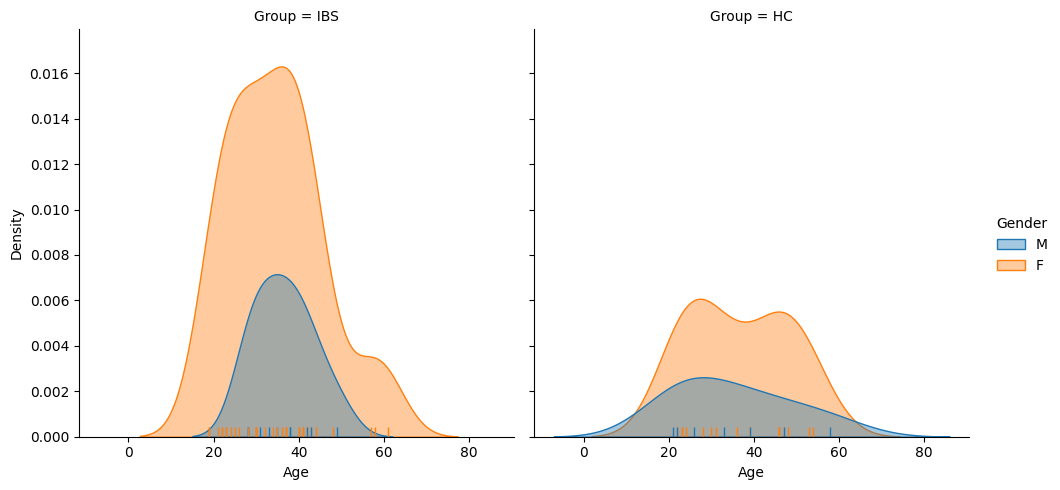

In [25]:
plt.figure(figsize=(10, 6))
sns.displot(df, x='Age', hue='Gender', col='Group', kind='kde', fill=True, rug=True, alpha=0.4, multiple="layer") # layer")
plt.savefig(f"{OVERLEAF_dir}/Figs/Age_dist_IBS_and_HC_in_M_vs_F.pdf")
plt.show()
plt.show()

<Figure size 1000x600 with 0 Axes>

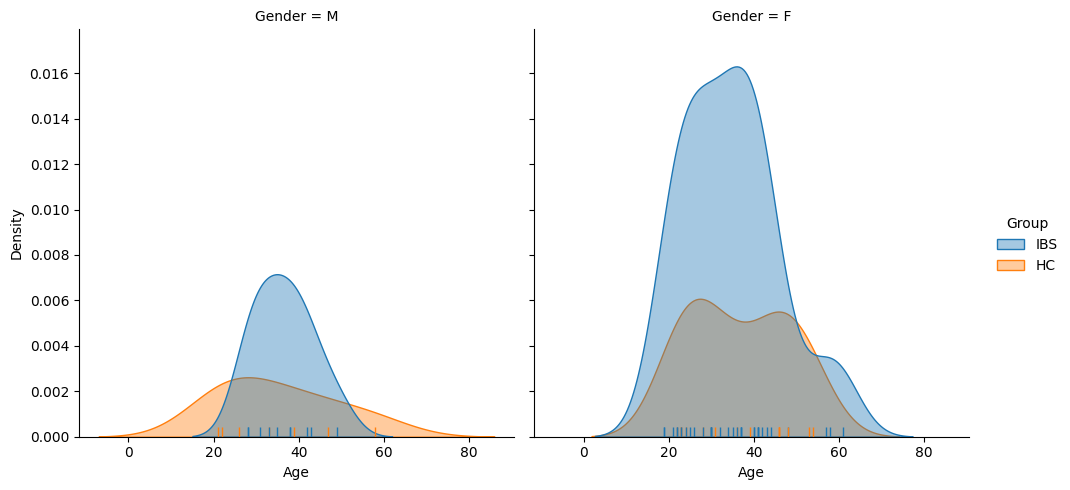

In [26]:
plt.figure(figsize=(10, 6))
sns.displot(df, x='Age', hue='Group', col='Gender', kind='kde', fill=True, rug=True, alpha=0.4, multiple="layer")
#           height=8, aspect=1.7) # layer")
plt.savefig(f"{OVERLEAF_dir}/Figs/Age_dist_M_and_F_in_IBS_vs_HC.pdf")
plt.show()
plt.show()

In [27]:
df_IBS = df[df['Group']=='IBS']
df_HC = df[df['Group']=='HC']
df_combined = pd.concat([df_IBS, df_HC], ignore_index=True)

df_combinded = pd.concat([df_IBS, df_HC], ignore_index=True)

df_combined.groupby(['Group', 'Gender']).count().T

Group              HC    IBS    
Gender              F  M   F   M
BG_ID              15  7  34  10
Age                15  7  34  10
Inhibition         15  7  34  10
Shifting           15  7  34  10
Emotional_control  15  7  34  10
Self_monitoring    15  7  34  10
Initiate           15  7  34  10
Working_memory     15  7  34  10
Planning           15  7  34  10
Task_monitoring    15  7  34  10
Organization       15  7  34  10
HADS_anx           11  6  30  10
HADS_dep           11  6  30  10
HADS_tot           11  6  30  10
IBS-SSS            11  6  30  10
RBANS              11  6  30  10

In [28]:
print('Age characteristics by Group and Gender:')
np.round(df_combined.groupby(['Group', 'Gender']).Age.describe(),2)

Age characteristics by Group and Gender:


count   mean    std   min    25%   50%   75%   max
Group Gender                                                    
HC    F        15.0  36.60  11.54  22.0  26.00  36.0  46.0  54.0
      M         7.0  35.14  13.78  21.0  24.00  33.0  43.0  58.0
IBS   F        34.0  34.59  11.03  19.0  25.25  34.5  41.0  61.0
      M        10.0  36.50   6.85  28.0  31.50  36.5  41.0  49.0

In [29]:
df_crosstab = pd.crosstab(index=[df['Group'], df['Gender']], columns=[df['Age']]).T # [df_age_kde['x_range'], df_age_kde['density_estimate']]).T 
print(len(df_crosstab))
#df_crosstab['x'] = df_crosstab.index

#my_list = list(df_age_kde['x_range'])
#sub_list = list(df_crosstab['x'])

#indexes = [i for i, x in enumerate(my_list)] 


#df_crosstab['y'] = df_age_kde['density_estimate']
df_crosstab

32


Group  HC    IBS   
Gender  F  M   F  M
Age                
19.0    0  0   2  0
21.0    0  1   1  0
22.0    1  1   2  0
23.0    2  0   2  0
24.0    1  0   1  0
25.0    0  0   1  0
26.0    0  1   1  0
28.0    1  0   1  2
30.0    1  0   4  0
31.0    1  0   0  1
32.0    0  0   1  0
33.0    0  1   0  1
34.0    0  0   1  0
35.0    0  0   1  1
36.0    1  0   1  0
37.0    0  0   3  0
38.0    0  0   0  2
39.0    1  1   0  0
40.0    0  0   2  0
41.0    0  0   3  0
42.0    0  0   1  1
43.0    0  0   1  1
44.0    0  0   1  0
46.0    3  0   0  0
47.0    0  1   0  0
48.0    1  0   1  0
49.0    0  0   0  1
53.0    1  0   0  0
54.0    1  0   0  0
57.0    0  0   1  0
58.0    0  1   1  0
61.0    0  0   1  0

In [30]:
df_IBS_M = df_IBS[df_IBS['Gender']=='M']
df_IBS_M['Group_Gender']= list(repeat('IBS_M', len(df_IBS_M)))

df_IBS_F = df_IBS[df_IBS['Gender']=='F']
df_IBS_F['Group_Gender']= list(repeat('IBS_F', len(df_IBS_F)))

df_HC_M = df_HC[df_HC['Gender']=='M']
df_HC_M['Group_Gender']= list(repeat('HC_M', len(df_HC_M)))


df_HC_F = df_HC[df_HC['Gender']=='F']
df_HC_F['Group_Gender']= list(repeat('HC_F', len(df_HC_F)))

df_Gender_combinded = pd.concat([df_IBS_M, df_IBS_F, df_HC_M, df_HC_M], ignore_index=True)


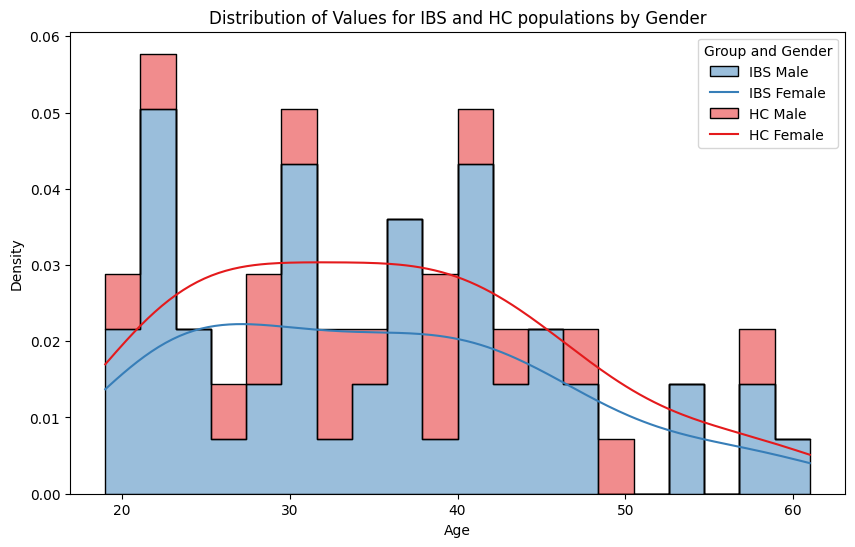

In [31]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_combined,
    x=variable_name,  # Replace 'Value' with the column you want to plot
    hue='Gender',
    multiple='stack',
    palette='Set1',  # Choose a color palette
    edgecolor='black',
    bins=20,
    kde=True,
    element='step',
    stat='density',  # Use 'density' to normalize histograms
)

plt.title('Distribution of Values for IBS and HC populations by Gender')
plt.xlabel(variable_name)  # Replace 'Value' with the column name you want to plot
plt.ylabel('Density')

# Add legend
legend_labels = ['IBS Male', 'IBS Female', 'HC Male', 'HC Female']
plt.legend(title='Group and Gender', labels=legend_labels, loc='upper right')

plt.show()

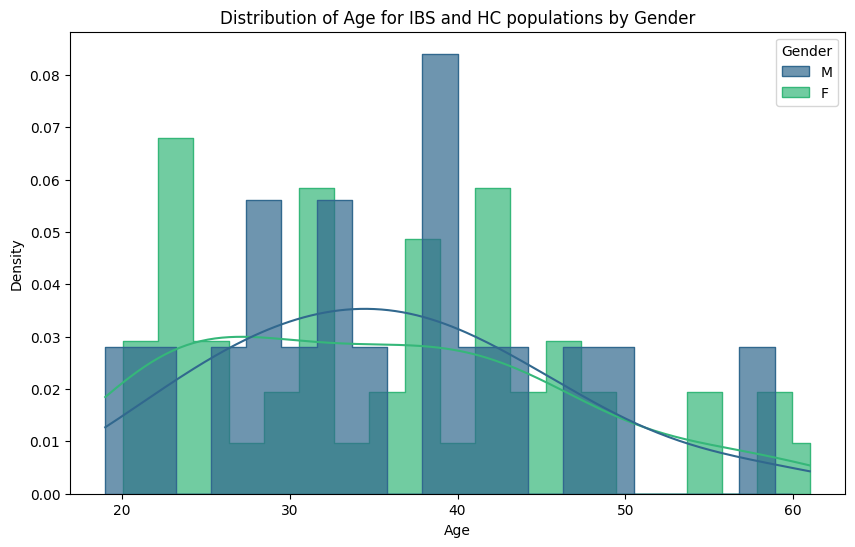

In [32]:
plt.figure(figsize=(10, 6))

# Create a histplot with hue based on gender and separate datasets for IBS and HC
sns.histplot(data=df_combined, x=variable_name, hue='Gender', multiple='dodge', kde=True, element='step', stat='density', common_norm=False, palette='viridis', alpha=0.7, bins=20, linewidth=1)

# Customize the plot
plt.title(f'Distribution of {variable_name} for IBS and HC populations by Gender')
plt.xlabel(variable_name)
plt.ylabel('Density')

# Display the plot
plt.show()


### BRIEF variables

In [33]:
# brief_scale_list = clin_scale_list_1
brief_scale_list = ['Age', 'Inhibition', 'Shifting', 'Emotional_control', 'Self_monitoring', 'Initiate', 'Working_memory',
       'Planning', 'Task_monitoring', 'Organization']
brief_scale_list

['Age',
 'Inhibition',
 'Shifting',
 'Emotional_control',
 'Self_monitoring',
 'Initiate',
 'Working_memory',
 'Planning',
 'Task_monitoring',
 'Organization']

In [34]:
# df3 = df_cat_1 = df_cat_1_dropna
#df3 = df2[['BG_ID'] + ['Gender'] + ['Group'] + brief_scale_list]
df3 = df[['BG_ID'] + ['Gender'] + ['Group'] + brief_scale_list]
df3.shape

(66, 13)

In [35]:
df3_IBS = df3[df3['Group'] == 'IBS']
df3_HC = df3[df3['Group'] == 'HC']

n_IBS = len(df3_IBS)
n_HC = len(df3_HC)

print(f'n_IBS: {n_IBS}, n_HC: {n_HC}')

n_IBS: 44, n_HC: 22


### Making a print to file of a $\LaTeX$ table on BRIEF variables

In [36]:
OVERLEAF = True
table_tex = 'table_1_new.tex'
cohend_func = cohen_d

print(OVERLEAF)
make_latex_table_IBS_HC(OVERLEAF, OVERLEAF_dir, table_tex, brief_scale_list, df3_IBS, df3_HC, cohend_func, max_length)

True
Writing to /Users/arvid/Dropbox/Apps/Overleaf/Executive_function_in_IBS/table_1_new.tex for synching of LaTeX table!
Latex table wiritten to disk


In [37]:
df4 = df[['BG_ID', 'Gender', 'Group', 'HADS_anx', 'HADS_dep', 'HADS_tot', 'IBS-SSS']]
df5 = df4.dropna()
df5.shape

(57, 7)

In [38]:
df5_IBS = df5[df5['Group'] == 'IBS']
df5_HC = df5[df5['Group'] == 'HC']

m_IBS = len(df5_IBS)
m_HC = len(df5_HC)

print(f'n_IBS: {m_IBS}, n_HC: {m_HC}')

n_IBS: 40, n_HC: 17


### Making a print to file of a $\LaTeX$ table on HADS and IBS-SSS variables

In [39]:
OVERLEAF = True
table_tex = 'table_2_new.tex'
cohend_func = cohen_d
other_scale_list = ['HADS_anx', 'HADS_dep', 'HADS_tot', 'IBS-SSS']

print(OVERLEAF)
make_latex_table_IBS_HC(OVERLEAF, OVERLEAF_dir, table_tex, other_scale_list, df5_IBS, df5_HC, cohend_func, max_length)

True
Writing to /Users/arvid/Dropbox/Apps/Overleaf/Executive_function_in_IBS/table_2_new.tex for synching of LaTeX table!
Latex table wiritten to disk


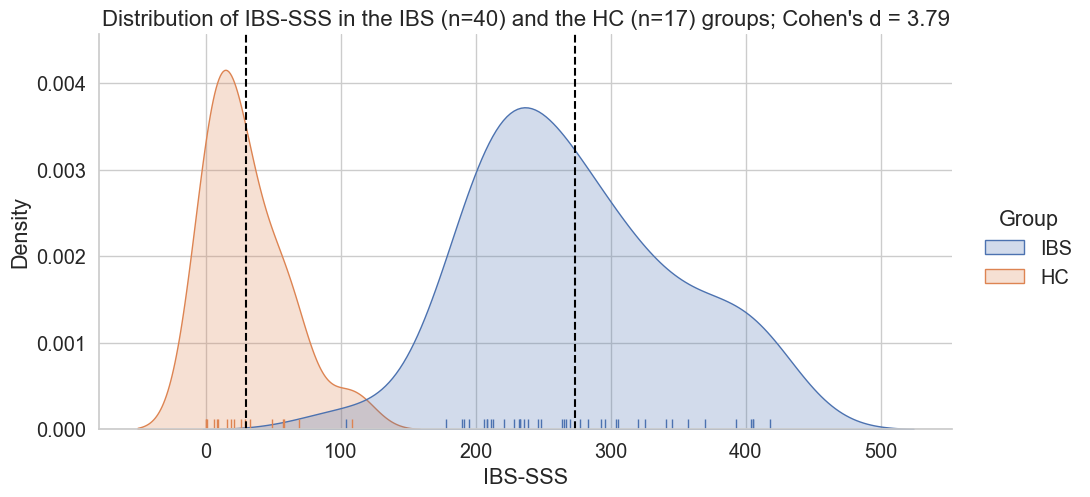

In [40]:
sns.set_theme(style="whitegrid", font_scale = 1.3) # palette="pastel")

visualize_variable_dist_IBS_HC(df5_IBS, df5_HC, 'IBS-SSS', 'IBS-SSS', cohen_d)

plt.savefig(f"{OVERLEAF_dir}/Figs/IBS-SSS_dist_in_IBS_vs_HC.pdf")
plt.show()